In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torchmetrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random

> ### Getting a dataset (Fashion MNIST)

In [2]:
train_data = torchvision.datasets.FashionMNIST(root='data', train=True, download=True,
                                               transform=ToTensor(),
                                               target_transform=None)

In [3]:
test_data = torchvision.datasets.FashionMNIST(root='data', train=False, download=True,
                                              transform=ToTensor(),
                                              target_transform=None)

> ### Visualizing our data

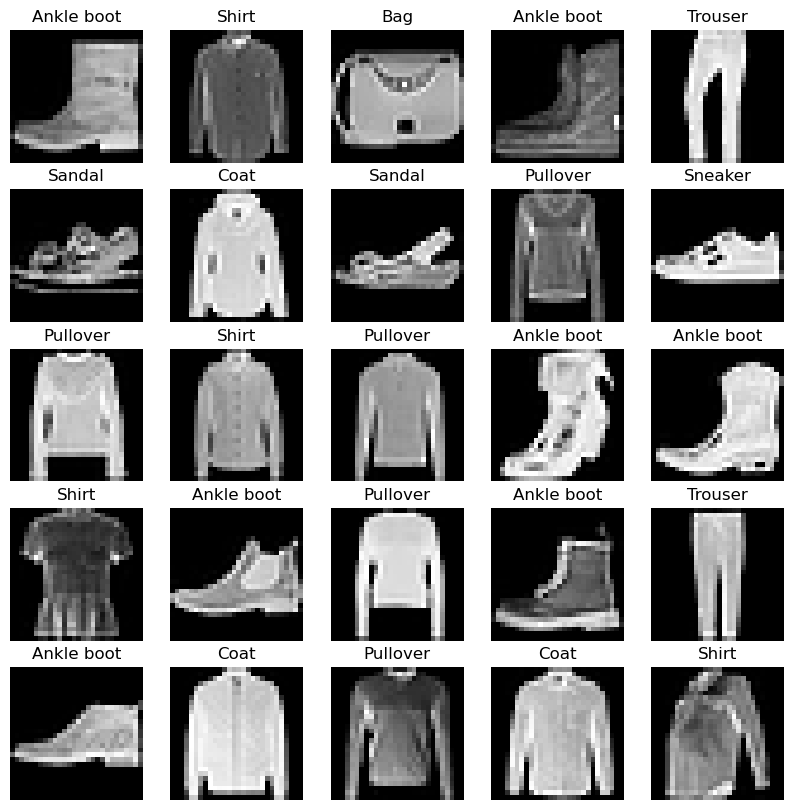

In [4]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows , cols = 5, 5

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=(1, )).item()
    img, label = train_data.data[random_idx], train_data.targets[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis('off')

> ## Building up gradually

+ We'll start with a crappy model and then build up on it gradually<br><br>

> ### Function for training LOOP

In [5]:
def train_model(model, loss_fn, optimizer, tr_data, epochs, batch_size,
                val_split=0.2):
    
    tr_losses = []
    tr_accuracies = []
    val_losses = []
    val_accuracies = []
    
    total_samples = len(tr_data)
    tr_size = int((1 - val_split) * total_samples)
    val_size = total_samples - tr_size
    
    tr_data, val_data = torch.utils.data.random_split(tr_data, [tr_size, val_size])
    
    
    tr_dataloader = torch.utils.data.DataLoader(tr_data, batch_size=batch_size,
                                                shuffle=True)
    
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                                 shuffle=False)
    
    total_batches = (len(tr_dataloader) + len(val_dataloader)) * epochs
    pbar = tqdm(total=total_batches)
    
    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        tr_accuracy = 0
        for tr_X, tr_y in tr_dataloader:
            tr_predictions = model(tr_X)
            loss = loss_fn(tr_predictions, tr_y)
            tr_loss += loss.item()
            tr_accuracy += accuracy(tr_predictions, tr_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)
        tr_accuracy /= len(tr_dataloader)
        tr_loss /= len(tr_dataloader)
        tr_losses.append(tr_loss)
        tr_accuracies.append(tr_accuracy)
        
        with torch.no_grad():
            val_loss = 0
            val_accuracy = 0
            for val_X, val_y in val_dataloader:
                val_predictions = model(val_X)
                loss  = loss_fn(val_predictions, val_y)
                val_loss += loss.item()
                val_accuracy += accuracy(val_predictions, val_y)
                pbar.update(1)
            val_accuracy /= (len(val_dataloader))
            val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch: {epoch + 1:2d} | tr_loss: {tr_loss:.4f} | val_loss: {val_loss:.4f} |  tr_acc: {tr_accuracy:.4f} | val_acc: {val_accuracy:.4f} |")
        
    return {"trained_model": model, "tr_losses": tr_losses,
            "val_losses": val_losses, "tr_accuracies": tr_accuracies,
            "val_accuracies": val_accuracies}

> ## Function for model evaluation

In [6]:
def eval_model(model, test_data, loss_fn):
    ts_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                                                shuffle=False)
    loss, acc = 0, 0
    with torch.no_grad():
        for X, y in tqdm(ts_dataloader):
            predictions = model(X)
            loss += loss_fn(predictions, y).item()
            acc += accuracy(predictions, y)
        acc /= (len(ts_dataloader))
        loss /= len(ts_dataloader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_accuracy": acc}

> #### A crappy linear model

In [65]:
class FashionMINIST_model_0(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=10)            
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [157]:
epochs = 2
learning_rate = 0.1
BATCH_SIZE = 32

model_0 = FashionMINIST_model_0(input_shape=784, hidden_units=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [158]:
tr_dict = train_model(model_0, loss_fn, optimizer, train_data, epochs, BATCH_SIZE)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch:  1 | tr_loss: 0.5960 | tr_acc: 0.790 | val_loss: 0.487 | val_acc: 0.827
Epoch:  2 | tr_loss: 0.4800 | tr_acc: 0.830 | val_loss: 0.479 | val_acc: 0.832


In [159]:
eval_dict = eval_model(tr_dict["trained_model"], test_data, loss_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [160]:
eval_dict

{'model_name': 'FashionMINIST_model_0',
 'model_loss': 0.5000155638582029,
 'model_accuracy': tensor(0.8252)}

> #### A non-linear model

In [51]:
class FashionMNIST_model_1(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=10),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [56]:
epochs = 3
learning_rate = 0.1
BATCH_SIZE = 32

model_1 = FashionMNIST_model_1(input_shape=784, hidden_units=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [57]:
tr_dict = train_model(model_1, loss_fn, optimizer, train_data, epochs, BATCH_SIZE)

  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch:  1 | tr_loss: 0.6764 | val_loss: 0.5310 |  tr_acc: 0.7590 | val_acc: 0.8196 |
Epoch:  2 | tr_loss: 0.5066 | val_loss: 0.4773 |  tr_acc: 0.8210 | val_acc: 0.8303 |
Epoch:  3 | tr_loss: 0.4748 | val_loss: 0.4676 |  tr_acc: 0.8301 | val_acc: 0.8330 |


In [58]:
tr_dict

{'trained_model': FashionMNIST_model_1(
   (layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=10, bias=True)
     (2): ReLU()
     (3): Linear(in_features=10, out_features=10, bias=True)
     (4): ReLU()
   )
 ),
 'tr_losses': [0.6763978428641955, 0.5065658765633901, 0.4748184751023849],
 'val_losses': [0.531025918006897, 0.4772588533163071, 0.4675967785914739],
 'tr_accuracies': [tensor(0.7590), tensor(0.8210), tensor(0.8301)],
 'val_accuracies': [tensor(0.8196), tensor(0.8303), tensor(0.8330)]}

In [59]:
eval_dict = eval_model(tr_dict["trained_model"], test_data, loss_fn)
eval_dict

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNIST_model_1',
 'model_loss': 0.48125949906655396,
 'model_accuracy': tensor(0.8248)}

> ### A better model: CNN

+ This is the replication of TinyVGG model from  the CNN explainer website<br><br>

In [6]:
class FashionMNIST_VGG(nn.Module):
    def __init__(self, input_shape, hidden_units):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),            
            nn.ReLU(),            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),            
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),            
            nn.ReLU(),            
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),            
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=10)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [7]:
epochs = 3
learning_rate = 0.1
BATCH_SIZE = 32

model_vgg = FashionMNIST_VGG(input_shape=1, hidden_units=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg.parameters(), lr=learning_rate)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [ ]:
tr_dict = train_model(model_vgg, loss_fn, optimizer, train_data, epochs, BATCH_SIZE)

  0%|          | 0/5625 [00:00<?, ?it/s]

In [43]:
eval_dict = eval_model(tr_dict["trained_model"], test_data, loss_fn)
eval_dict

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNIST_VGG',
 'model_loss': 0.33764097944330485,
 'model_accuracy': tensor(0.8766)}

> ### Making random predictions with our VGG model

In [128]:
def make_predictions(model, data):
    prediction_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            raw_logits = model(sample)
            prediction_probs.append(torch.softmax(raw_logits.squeeze(), dim=0))
    return torch.argmax(torch.stack(prediction_probs), dim=1)

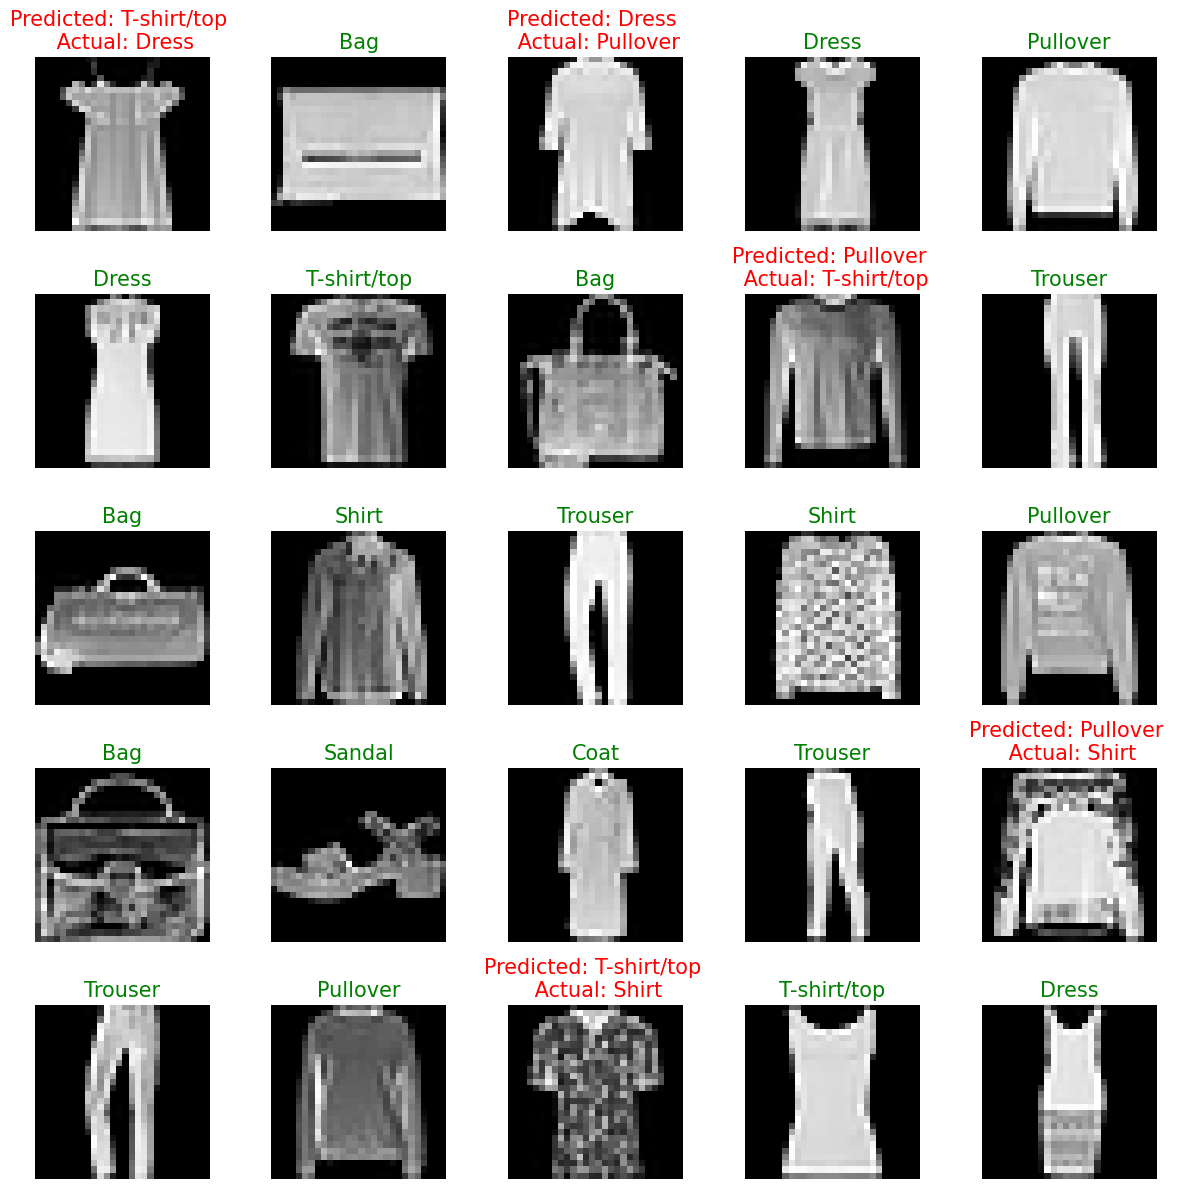

In [147]:
torch.manual_seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=25):
    test_samples.append(sample)
    test_labels.append(label)
test_samples = torch.stack(test_samples)    

model_predictions = make_predictions(model_vgg, test_samples)


fig = plt.figure(figsize=(12, 12))
rows , cols = 5, 5

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(test_samples[i - 1].squeeze(), cmap='gray')
    if (model_predictions[i - 1] == test_labels[i - 1]):
        plt.title(test_data.classes[test_labels[i - 1]], color='green', fontsize=15)
    else:
        predicted = f"Predicted: {test_data.classes[model_predictions[i - 1]]}"
        actual = f"Actual: {test_data.classes[test_labels[i - 1]]}"
        plt.title(f"{predicted} \n {actual}", color='red', fontsize=15)
    plt.axis('off')

plt.tight_layout()
plt.show()

> ### Making a confusion matrix

In [191]:
model_predictions = []

ts_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                                                shuffle=False)
with torch.no_grad():
    for X, y in tqdm(ts_dataloader):
        model_predictions.append(model_vgg(X))
    
model_predictions = torch.concatenate(model_predictions)
model_predictions = torch.softmax(model_predictions, dim=1)
model_predictions = torch.argmax(model_predictions, dim=1)

  0%|          | 0/313 [00:00<?, ?it/s]

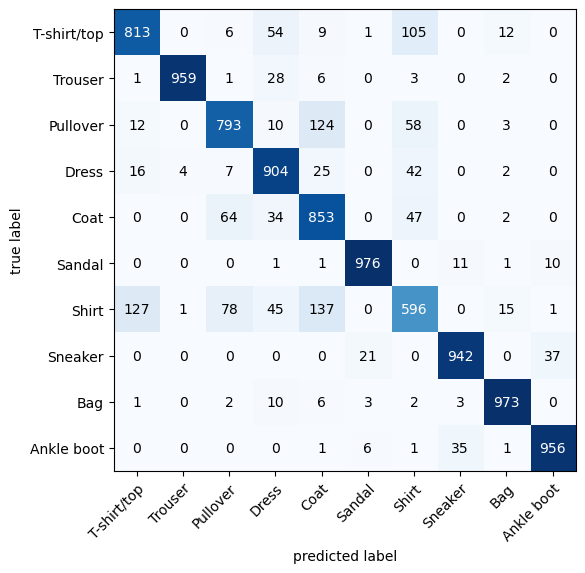

In [211]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat_tensor = ConfusionMatrix(task='multiclass', num_classes=10)
confmat_tensor = confmat_tensor(model_predictions, test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                               class_names=test_data.classes,
                               figsize=(6, 6))